In [1]:
import os
import torch
import json
import random
import shutil
import wandb
import pickle 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from pathlib import Path
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
from transformers import CLIPProcessor, CLIPModel
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.models import vit_b_32, ViT_B_32_Weights


## Test

In [10]:
#model_name='fine_tuned_clip_model_ge_cpc_01_2'
#model_name='fine_tuned_clip_model_cpc'
#model_name='fine_tuned_clip_model_2'
#model_name='fine_tuned_clip_model_12_v2'
#model_name='clip_model_e2ett_256_2'
#model_name='clip_model_e2e_full_256_2_'


#model_name='fine_tuned_clip_model_ge_hier_07_new15_best'
#model_name='fine_tuned_clip_model_ge_hier_a01_t005_p2_best'
model_name='fine_tuned_clip_model_ge_hier_a01_t01_best'
#model_name='fine_tuned_clip_model_ge_hier_a02_t01_p_best'

#model_name='fine_tuned_clip_model_ge_hier_09_3_10ep_best'
#model_name='fine_tuned_clip_model_ge_hier_01_3_v2'
#model_name='fine_tuned_clip_model_ge_hier_01_2_5ep'
#model_name='fine_tuned_clip_model_ge_hier_01_new_best'
#model_name='fine_tuned_clip_model_ge_hier_0_new07_best'
#model_name='baseline_clip16'
class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        
        image = torchvision.io.read_image(self.image_paths[idx])
        # Convert to float and normalize to [0, 1]
        image = image.float() / 255.0
        # Handle grayscale images (1 channel) by repeating to 3 channels
        if image.shape[0] == 1:
            image = image.repeat(3, 1, 1)
        # Ensure we have 3 channels (RGB)
        elif image.shape[0] == 4:  # RGBA
            image = image[:3]  # Take only RGB channels
            
        if self.transform:
            image = self.transform(image)
        return image, self.image_paths[idx]

class ImageRetrieval:
    def __init__(self, device='cuda' if torch.cuda.is_available() else 'cpu'):
        # Load CLIP 
        self.model = CLIPModel.from_pretrained(f'models/patent-wise/{model_name}').to(device)
        #clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16").to(device)
    
       
        # 2. Load the saved state dict from the pickle file
        #with open(f'../src/models_storage/hyper/joint_clip_hyperbolic/{model_name}.pkl', 'rb') as f:
            #saved_state_dict = pickle.load(f)
        #with open(f'../src/models_storage/hyper/joint_clip_hyperbolic//clip_model_best.pt', 'rb') as f:
            #saved_state_dict = torch.load(f)
        # 3. Load the state dict into your model
        #clip_model.load_state_dict(saved_state_dict)
        #clip_model = clip_model.to(device)
        
        #self.model =clip_model
        self.model.eval()
        self.device = device
        self.model_name = model_name 
        
        # Define image transformations for already loaded tensors
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.Normalize(
                mean=[0.48145466, 0.4578275, 0.40821073],
                std=[0.26862954, 0.26130258, 0.27577711]
            )
        ])
        
        self.embeddings = None
        self.image_paths = None

    @torch.no_grad()
    def encode_dataset(self, image_paths, batch_size=128):
        """Encode all images in the dataset"""
        dataset = ImageDataset(image_paths, self.transform)
        dataloader = DataLoader(
            dataset,
            batch_size=128,
            shuffle=True,
            num_workers=16,
            pin_memory=True,
            prefetch_factor=8,
            persistent_workers=True
        )

        all_embeddings = []
        all_paths = []
        
        print("Encoding dataset...")
        for images, paths in tqdm(dataloader):
            images = images.to(self.device)
            
            embeddings = self.model.get_image_features(pixel_values=images)
            all_embeddings.append(embeddings.cpu().numpy())
            all_paths.extend(paths)
        
        self.embeddings = np.vstack(all_embeddings)
        self.image_paths = all_paths
        print(f"Encoded {len(self.image_paths)} images")

        # Save embeddings to file
        np.save(f'embeddings/{model_name}.npy', self.embeddings)
        with open(f'embeddings/{model_name}.json', 'w') as f:
            json.dump(all_paths, f)

    def load_embeddings(self):
        """Load embeddings from file if they exist"""
        if os.path.exists(f'embeddings/{model_name}.npy') and os.path.exists(f'embeddings/{model_name}.json'):
            self.embeddings = np.load(f'embeddings/{model_name}.npy')
            with open(f'embeddings/{model_name}.json', 'r') as f:
                self.image_paths = json.load(f)
            print(f"Loaded {len(self.image_paths)} embeddings from file.")
        else:
            print("No embeddings found. Please encode the dataset first.")

    @torch.no_grad()
    def encode_single_image(self, image_path):
        """Encode a single test image"""
        # Using torchvision.io instead of PIL
        image = torchvision.io.read_image(image_path)
        # Convert to float and normalize to [0, 1]
        image = image.float() / 255.0
        # Handle grayscale images (1 channel) by repeating to 3 channels
        if image.shape[0] == 1:
            image = image.repeat(3, 1, 1)
        # Ensure we have 3 channels (RGB)
        elif image.shape[0] == 4:  # RGBA
            image = image[:3]  # Take only RGB channels
            
        # Apply transform
        if self.transform:
            image = self.transform(image)
        
        # Add batch dimension and move to device
        inputs = image.unsqueeze(0).to(self.device)
        
        # Get image features
        embedding = self.model.get_image_features(pixel_values=inputs)
        return embedding.cpu().numpy()

    def retrieve_similar_images(self, query_image_path, k=20):
        """Retrieve k most similar images"""
        if self.embeddings is None:
            raise ValueError("No database embeddings found. Please encode dataset first.")
        
        # Encode query image
        query_embedding = self.encode_single_image(query_image_path)
        
        # Compute cosine similarities
        similarities = cosine_similarity(query_embedding, self.embeddings)[0]
        
        # Get top k similar images
        top_k_idx = np.argsort(similarities)[-k:][::-1]
        top_k_similarities = similarities[top_k_idx]
        top_k_paths = [self.image_paths[idx] for idx in top_k_idx]
        
        return list(zip(top_k_paths, top_k_similarities))




In [11]:
if __name__ == "__main__":
    # Initialize retrieval system
    retrieval = ImageRetrieval()
    
    # Read all images from the gallery folder
    gallery_folder = "../data/2019/test_gallery_comp"
    query_folder = "../data/2019/test_query_comp"
    
    # Load ground truth
    with open('../data/2019/ground_truth_2019.json', 'r') as f:
        ground_truth = json.load(f)
    

    valid_extensions = {'.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG'}
    
    gallery_image_paths = [
        str(path) for path in Path(gallery_folder).rglob("*")
        if path.suffix in valid_extensions
    ]
    
    print(f"Found {len(gallery_image_paths)} images in the gallery")
    
    
    retrieval.load_embeddings()
    
    # If embeddings are not loaded, encode the dataset
    if retrieval.embeddings is None:
        retrieval.encode_dataset(gallery_image_paths)

    query_image_paths = [
        str(path) for path in Path(query_folder).rglob("*")
        if path.suffix in valid_extensions
    ]
     
    def calculate_mrr_at_k(retrieved_paths, positives, k):
        """
        Calculate MRR@k for a single query
        """
        for rank, path in enumerate(retrieved_paths[:k], 1):
            if path in positives:
                return 1.0 / rank
        return 0.0
    def calculate_precision_at_k(retrieved_paths, positives, k):
        """
        Calculate precision@k for the single query
        """
        retrieved_at_k = retrieved_paths[:k]
        relevant_at_k = len(set(retrieved_at_k).intersection(positives))
        return relevant_at_k / k if k <= len(retrieved_paths) else 0.0

    # Evaluation metrics
    ap_scores = []
    ndcg_scores = []
    recall_5 = []
    recall_10 = []
    recall_20 = []
    reciprocal_ranks = []  # Overall MRR
    reciprocal_ranks_5 = []  # MRR@5
    reciprocal_ranks_20 = []# MRR@20
    precision_5 = []  # Precision@5
    precision_10 = []  # Precision@10
    precision_20 = []  # Precision@20
    
    
    
    query_dataset = ImageDataset(query_image_paths, retrieval.transform)
    query_dataloader = DataLoader(
        query_dataset,
        batch_size=128,  # Adjust batch size as needed
        shuffle=False,  # Keep order for evaluation
        num_workers=16,
        pin_memory=True,
        prefetch_factor=4,
        persistent_workers=True
    )

    # Encode all query images in batches
    print("\nEncoding query images in batches...")
    all_query_embeddings = []
    all_query_paths = []
    with torch.no_grad():
        for batch_images, batch_paths in tqdm(query_dataloader):
            batch_images = batch_images.to(retrieval.device)
            batch_embeddings = retrieval.model.get_image_features(pixel_values=batch_images)
            all_query_embeddings.append(batch_embeddings.cpu().numpy())
            all_query_paths.extend(batch_paths)

    # Concatenate all embeddings
    all_query_embeddings = np.vstack(all_query_embeddings)

    # Calculate similarities for all queries at once
    print("Computing similarities...")
    all_similarities = cosine_similarity(all_query_embeddings, retrieval.embeddings)
    count=0
    # Process each query result
    print("Processing results...")
    for i, query_path in enumerate(tqdm(all_query_paths)):
        query_name = Path(query_path).name
        if query_name not in list(ground_truth.keys()):
            count+=1
            continue
        
        
        # Get similarities for this query
        similarities = all_similarities[i]
        
        # Get top k indices
        top_k_idx = np.argsort(similarities)[::-1]
        retrieved_paths = [Path(retrieval.image_paths[idx]).name for idx in top_k_idx]
        
        # Get ground truth positives
        positives = set(ground_truth[query_name]['patent_positives'])
        
        # Calculate MRR, MRR@5, and MRR@20
        # Overall MRR
        mrr = calculate_mrr_at_k(retrieved_paths, positives, len(retrieved_paths))
        reciprocal_ranks.append(mrr)
        
        # MRR@5
        mrr_5 = calculate_mrr_at_k(retrieved_paths, positives, 5)
        reciprocal_ranks_5.append(mrr_5)
        
        # MRR@20
        mrr_20 = calculate_mrr_at_k(retrieved_paths, positives, 20)
        reciprocal_ranks_20.append(mrr_20)
        
        # Calculate Precision@5 and Precision@10 for the single query
        precision_at_5 = calculate_precision_at_k(retrieved_paths, positives, 5)
        precision_at_10 = calculate_precision_at_k(retrieved_paths, positives, 10)
        precision_at_20 = calculate_precision_at_k(retrieved_paths, positives, 20)
        precision_5.append(precision_at_5)
        precision_10.append(precision_at_10)
        precision_20.append(precision_at_20)
        
        # Calculate other metrics
        # AP calculation
        relevant = 0
        ap = 0
        for j, path in enumerate(retrieved_paths, 1):
            if path in positives:
                relevant += 1
                precision = relevant / j
                ap += precision
        ap = ap / len(positives) if len(positives) > 0 else 0
        ap_scores.append(ap)
        # AP calculation
        relevant = 0
        ap = 0
        for j, path in enumerate(retrieved_paths, 1):
            if path in positives:
                relevant += 1
                precision = relevant / j
                ap += precision
        ap = ap / len(positives) if len(positives) > 0 else 0
        # NDCG calculation
        dcg = 0
        idcg = sum(1 / np.log2(j + 2) for j in range(len(positives)))
        for j, path in enumerate(retrieved_paths):
            if path in positives:
                dcg += 1 / np.log2(j + 2)
        ndcg = dcg / idcg if idcg > 0 else 0
        ndcg_scores.append(ndcg)
        
        # Recall@k calculation
        for k, recall_list in [(5, recall_5), (10, recall_10), (20, recall_20)]:
            retrieved_at_k = set(retrieved_paths[:k])
            recall = len(retrieved_at_k.intersection(positives)) / len(positives) if len(positives) > 0 else 0
            recall_list.append(recall)
    
    # Calculate final metrics
    mrr = np.mean(reciprocal_ranks)
    mrr_5 = np.mean(reciprocal_ranks_5)
    mrr_20 = np.mean(reciprocal_ranks_20)
    mAP = np.mean(ap_scores)
    mNDCG = np.mean(ndcg_scores)
    mRecall_5 = np.mean(recall_5)
    mRecall_10 = np.mean(recall_10)
    mRecall_20 = np.mean(recall_20)
    avg_precision_5 = np.mean(precision_5)
    avg_precision_10 = np.mean(precision_10)
    avg_precision_20 = np.mean(precision_20)
    
    # Print results
    print("\nRetrieval Metrics:")
    print(f"MRR: {mrr:.3f}")
    print(f"MRR@5: {mrr_5:.3f}")
    print(f"MRR@20: {mrr_20:.3f}")
    print(f"mAP: {mAP:.3f}")
    print(f"mNDCG: {mNDCG:.3f}")
    print(f"Recall@5: {mRecall_5:.3f}")
    print(f"Recall@10: {mRecall_10:.3f}")
    print(f"Recall@20: {mRecall_20:.3f}")
    print(f"Precision@5: {avg_precision_5:.3f}")
    print(f"Precision@10: {avg_precision_10:.3f}")
    print(f"Precision@20: {avg_precision_20:.3f}")
    
    # Save results to file
    results = {
        'MRR': mrr,
        'MRR@5': mrr_5,
        'MRR@20': mrr_20,
        'mAP': mAP,
        'mNDCG': mNDCG,
        'Recall@5': mRecall_5,
        'Recall@10': mRecall_10,
        'Recall@20': mRecall_20,
        'Precision@5': avg_precision_5,
        'Precision@10': avg_precision_10,
        'Precision@20': avg_precision_20
    }
    
    # Save detailed results for analysis
    detailed_results = {
        'query_wise_metrics': {
            'reciprocal_ranks': reciprocal_ranks,
            'reciprocal_ranks@5': reciprocal_ranks_5,
            'reciprocal_ranks@20': reciprocal_ranks_20,
            'ap_scores': ap_scores,
            'ndcg_scores': ndcg_scores,
            'recall_5': recall_5,
            'recall_10': recall_10,
            'recall_20': recall_20,
            'precision_5': precision_5,
            'precision_10': precision_10,
            'precision_20': precision_20
        },
        'summary_metrics': results
    }
    
    with open(f'results/evaluation_results_{model_name}3jtarde.json', 'w') as f:
    #with open(f'results/evaluation_results_hyper_proj_cpc.json', 'w') as f:
        json.dump(detailed_results, f, indent=2)

Found 71955 images in the gallery
Loaded 71955 embeddings from file.

Encoding query images in batches...


100%|██████████| 16/16 [00:06<00:00,  2.30it/s]


Computing similarities...
Processing results...


100%|██████████| 1953/1953 [08:15<00:00,  3.94it/s]


Retrieval Metrics:
MRR: 0.709
MRR@5: 0.700
MRR@20: 0.707
mAP: 0.348
mNDCG: 0.576
Recall@5: 0.313
Recall@10: 0.381
Recall@20: 0.445
Precision@5: 0.351
Precision@10: 0.227
Precision@20: 0.138


In [ ]:
0.1 0

MRR: 0.783
MRR@5: 0.773
MRR@20: 0.781
mAP: 0.132
mNDCG: 0.644
Recall@5: 0.070
Recall@10: 0.088
Recall@20: 0.104
Precision@5: 0.450
Precision@10: 0.317
Precision@20: 0.216

0.1 0.1
MRR: 0.770
MRR@5: 0.759
MRR@20: 0.768
mAP: 0.128
mNDCG: 0.640
Recall@5: 0.067
Recall@10: 0.083
Recall@20: 0.099
Precision@5: 0.430
Precision@10: 0.307
Precision@20: 0.211
hoy
MRR: 0.785
MRR@5: 0.775
MRR@20: 0.783
mAP: 0.132
mNDCG: 0.645
Recall@5: 0.071
Recall@10: 0.087
Recall@20: 0.103
Precision@5: 0.446
Precision@10: 0.316
Precision@20: 0.217
Retrieval Metrics:
MRR: 0.709
MRR@5: 0.700
MRR@20: 0.707
mAP: 0.348
mNDCG: 0.576
Recall@5: 0.313
Recall@10: 0.381
Recall@20: 0.445
Precision@5: 0.351
Precision@10: 0.227
Precision@20: 0.138


0.1 0.7
MRR: 0.749
MRR@5: 0.737
MRR@20: 0.746
mAP: 0.123
mNDCG: 0.636
Recall@5: 0.064
Recall@10: 0.080
Recall@20: 0.095
Precision@5: 0.415
Precision@10: 0.292
Precision@20: 0.202

0.05 0.2
MRR: 0.811
MRR@5: 0.802
MRR@20: 0.809
mAP: 0.139
mNDCG: 0.651
Recall@5: 0.076
Recall@10: 0.095
Recall@20: 0.111
Precision@5: 0.472
Precision@10: 0.332
Precision@20: 0.227
MRR: 0.734
MRR@5: 0.726
MRR@20: 0.732
mAP: 0.374
mNDCG: 0.597
Recall@5: 0.334
Recall@10: 0.406
Recall@20: 0.471
Precision@5: 0.375
Precision@10: 0.240
Precision@20: 0.146

0.05 0.1
MRR: 0.813
MRR@5: 0.805
MRR@20: 0.812
mAP: 0.139
mNDCG: 0.651
Recall@5: 0.077
Recall@10: 0.096
Recall@20: 0.111
Precision@5: 0.479
Precision@10: 0.338
Precision@20: 0.228

proj 0.1
MRR: 0.820
MRR@5: 0.812
MRR@20: 0.818
mAP: 0.140
mNDCG: 0.652
Recall@5: 0.078
Recall@10: 0.097
Recall@20: 0.113
Precision@5: 0.485
Precision@10: 0.341
Precision@20: 0.229

New pj double
MRR: 0.795
MRR@5: 0.786
MRR@20: 0.794
mAP: 0.137
mNDCG: 0.648
Recall@5: 0.074
Recall@10: 0.092
Recall@20: 0.108
Precision@5: 0.453
Precision@10: 0.321
Precision@20: 0.220

In [6]:
import os, errno, pathlib
path = pathlib.Path("embeddings/probe.bin")
path.touch(exist_ok=True)

try:
    with path.open("wb", buffering=0) as f:          # unbuffered, single write
        f.write(b"\0" * 40_000_000)                  # 40 MB
except OSError as e:
    print("write failed:", e, "(errno", e.errno, ")")
else:
    print("write succeeded")


write succeeded


## Graph

### preprocess

In [2]:
def check_validation_pairs_same_patent(val_anchor_paths, val_positive_paths):
    
    """ Checks if each validation pair (anchor and positive image) belong to the same patent.

    The function assumes that the patent ID is the first part of the filename,
    separated by a hyphen. For example, for a filename "12345-sample.jpg", the patent ID is "12345".

    Args:
        val_anchor_paths (list): List of paths for anchor images in the validation set.
        val_positive_paths (list): List of paths for positive images in the validation set.
        
    Returns:
        mismatches (list): A list of tuples where each tuple contains:
            (anchor_path, positive_path, anchor_patent_id, positive_patent_id)
            for pairs that do not have the same patent.
    """
    mismatches = []
    

    # Loop over both lists simultaneously
    for anchor_path, positive_path in zip(val_anchor_paths, val_positive_paths):
        anchor_filename = os.path.basename(anchor_path)
        positive_filename = os.path.basename(positive_path)
        
        # Extract the patent ID (assumes it's before the first hyphen)
        anchor_patent = anchor_filename.split('-')[0]
        positive_patent = positive_filename.split('-')[0]
        
        if anchor_patent != positive_patent:
            mismatches.append((anchor_path, positive_path, anchor_patent, positive_patent))

    if mismatches:
        print(f"Found {len(mismatches)} validation pairs that do not belong to the same patent:")
        for anchor, positive, a_patent, p_patent in mismatches:
            print(f"Anchor: {anchor} (Patent: {a_patent}) | Positive: {positive} (Patent: {p_patent})")
    else:
        print("All validation pairs belong to the same patent.")

    return mismatches


In [3]:
def check_validation_pairs_same_patent(val_anchor_paths, val_positive_paths):
    
    """ Checks if each validation pair (anchor and positive image) belong to the same patent.

    The function assumes that the patent ID is the first part of the filename,
    separated by a hyphen. For example, for a filename "12345-sample.jpg", the patent ID is "12345".

    Args:
        val_anchor_paths (list): List of paths for anchor images in the validation set.
        val_positive_paths (list): List of paths for positive images in the validation set.
        
    Returns:
        mismatches (list): A list of tuples where each tuple contains:
            (anchor_path, positive_path, anchor_patent_id, positive_patent_id)
            for pairs that do not have the same patent.
    """
    mismatches = []
    

    # Loop over both lists simultaneously
    for anchor_path, positive_path in zip(val_anchor_paths, val_positive_paths):
        anchor_filename = os.path.basename(anchor_path)
        positive_filename = os.path.basename(positive_path)
        
        # Extract the patent ID (assumes it's before the first hyphen)
        anchor_patent = anchor_filename.split('-')[0]
        positive_patent = positive_filename.split('-')[0]
        
        if anchor_patent != positive_patent:
            mismatches.append((anchor_path, positive_path, anchor_patent, positive_patent))

    if mismatches:
        print(f"Found {len(mismatches)} validation pairs that do not belong to the same patent:")
        for anchor, positive, a_patent, p_patent in mismatches:
            print(f"Anchor: {anchor} (Patent: {a_patent}) | Positive: {positive} (Patent: {p_patent})")
    else:
        print("All validation pairs belong to the same patent.")

    return mismatches


In [4]:
def check_patent_overlap(train_anchor_paths, val_anchor_paths):
    """
    Check if there are patents present in both training and validation sets
    by comparing the first 10 digits of the image names.
    
    Args:
        train_anchor_paths: List of training image paths
        val_anchor_paths: List of validation image paths
        
    Returns:
        overlap_count: Number of overlapping patents
        overlap_patents: Set of overlapping patent IDs
    """
    # Extract patent IDs (first 10 digits of filename) from training set
    train_patents = set()
    for path in train_anchor_paths:
        filename = os.path.basename(path)
        # Extract the patent ID (first 10 digits)
        patent_id = filename[:19]
        train_patents.add(patent_id)
    
    # Extract patent IDs from validation set
    val_patents = set()
    overlap_patents = set()
    
    for path in val_anchor_paths:
        filename = os.path.basename(path)
        # Extract the patent ID (first 10 digits)
        patent_id = filename[:19]
        val_patents.add(patent_id)
        
        # Check if this patent is also in the training set
        if patent_id in train_patents:
            overlap_patents.add(patent_id)
    
    overlap_count = len(overlap_patents)
    
    # Print results
    print(f"Training set: {len(train_patents)} unique patents")
    print(f"Validation set: {len(val_patents)} unique patents")
    print(f"Overlap: {overlap_count} patents present in both sets ({overlap_count/len(val_patents)*100:.2f}% of validation)")
    
    if overlap_count > 0:
        print("First 5 overlapping patents:", list(overlap_patents))
    
    return overlap_count, overlap_patents

In [5]:

#with open('../src/graph_embeddings/image_ge_embeddings_GE_256_d512_l0.002_20_3_5ep.pkl', 'rb') as f:
with open('../src/graph_embeddings/image_ge_embeddings_GE_256_d512_l0.002_20_3.pkl', 'rb') as f:
  
    image_dict = pickle.load(f)

In [9]:
list(image_dict)[0]

'USD0806366-20180102-D00002_3.png'

Selected query image: USD0806928-20180102-D00001_1.png


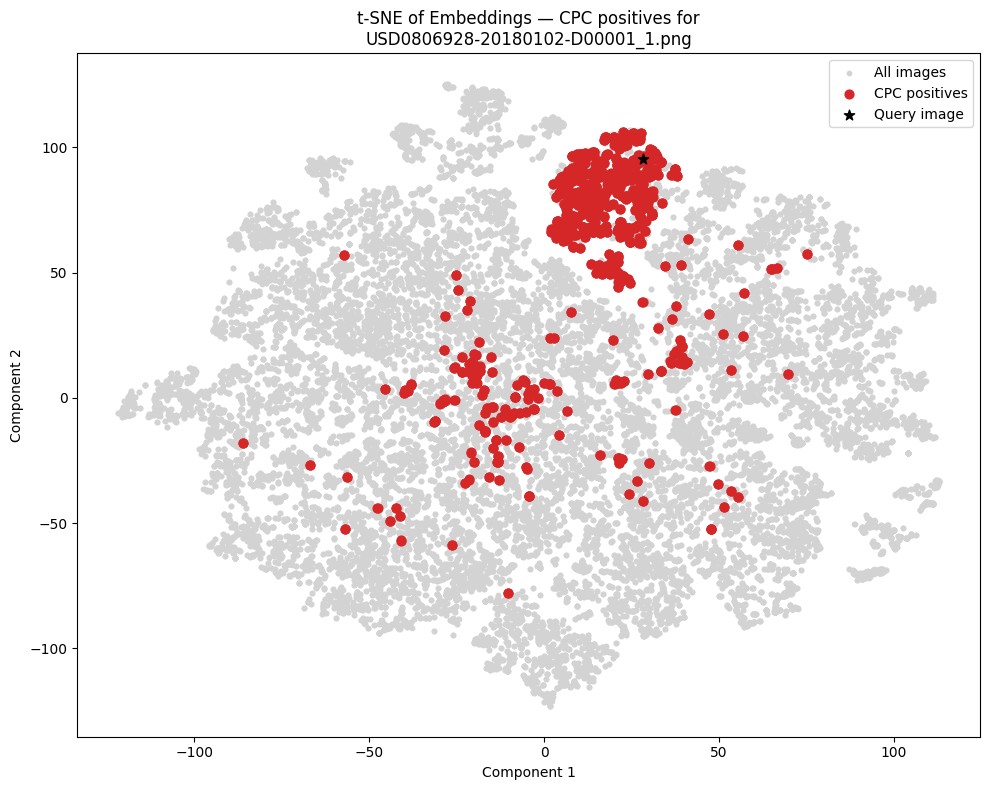

In [16]:
import pickle
import json
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import random

# ——— Parameters ———
EMB_PATH   = '../src/graph_embeddings/image_ge_embeddings_GE_256_d512_l0.002_20_3.pkl'
GT_JSON    = '../data/2018/ground_truth_2018_cpc.json'   # path to your JSON file
# You can hard-code a key here:
# QUERY_IMG = 'USD0836880-20190101-D00001_1.png'
# Or pick one at random:
# (below we load the JSON first)

# ——— Load data ———
with open(EMB_PATH, 'rb') as f:
    image_dict = pickle.load(f)

with open(GT_JSON, 'r') as f:
    gt = json.load(f)

# ——— Choose one query image ———
all_queries = list(gt.keys())
QUERY_IMG = 'USD0806928-20180102-D00001_1.png'
print(f"Selected query image: {QUERY_IMG}")

# ——— Prepare embeddings & t-SNE ———
filenames = list(image_dict.keys())
embeddings = np.stack([image_dict[f] for f in filenames])

tsne = TSNE(n_components=2, random_state=42)
emb2d = tsne.fit_transform(embeddings)

# Mapping filename → 2D point
idx_map = {fn: i for i, fn in enumerate(filenames)}

# ——— Get CPC positives for our query ———
cpc_list = gt[QUERY_IMG]['cpc_positives']
# Filter to those actually in your embeddings dict
cpc_list = [fn for fn in cpc_list if fn in idx_map]

# ——— Plot ———
plt.figure(figsize=(10, 8))

# Background: all points in light gray
plt.scatter(emb2d[:, 0], emb2d[:, 1], c='lightgray', s=10, label='All images')

# Highlight CPC-positives
xs = [emb2d[idx_map[fn], 0] for fn in cpc_list]
ys = [emb2d[idx_map[fn], 1] for fn in cpc_list]
plt.scatter(xs, ys, c='C3', s=40, label='CPC positives')

# Optionally highlight the query itself
qx, qy = emb2d[idx_map[QUERY_IMG]]
plt.scatter([qx], [qy], c='black', s=60, marker='*', label='Query image')

plt.title(f"t-SNE of Embeddings — CPC positives for\n{QUERY_IMG}")
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


In [6]:
# ---- Patent-aware split logic ---- #
def extract_patent_number_from_path(path):
    return Path(path).name.split('-')[0]

def create_patent_aware_split(anchors, positives, val_ratio=0.2):
    patent_to_indices = {}
    for i, path in enumerate(anchors):
        patent = extract_patent_number_from_path(path)
        if patent not in patent_to_indices:
            patent_to_indices[patent] = []
        patent_to_indices[patent].append(i)

    all_patents = list(patent_to_indices.keys())
    random.shuffle(all_patents)
    val_patents = set(all_patents[:int(len(all_patents) * val_ratio)])

    train_anchor_paths, train_positive_paths, val_anchor_paths, val_positive_paths = [], [], [], []

    for patent, indices in patent_to_indices.items():
        for i in indices:
            if patent in val_patents:
                val_anchor_paths.append(anchors[i])
                val_positive_paths.append(positives[i])
            else:
                train_anchor_paths.append(anchors[i])
                train_positive_paths.append(positives[i])

    return train_anchor_paths, train_positive_paths, val_anchor_paths, val_positive_paths

def check_patent_overlap(train_paths, val_paths):
    train_patents = set(extract_patent_number_from_path(p) for p in train_paths)
    val_patents = set(extract_patent_number_from_path(p) for p in val_paths)
    overlap = train_patents.intersection(val_patents)
    return len(overlap), overlap


### Fine tuning

In [7]:
import torch.nn as nn
epochs=8
model_name='fine_tuned_clip_model_ge_hier_a01_t01'

class MultiPositiveContrastiveLoss(torch.nn.Module):
    def __init__(self, temperature=0.1, graph_embedding_dict=None, alpha=0.1, device=None):
        super().__init__()
        self.temperature = temperature
        self.graph_embedding_dict = graph_embedding_dict
        self.alpha = alpha
        self.device = device

        # NEW: projection from graph space to image space
        self.graph_projection = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            
        ).to(self.device)
        self.image_projection = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            
        ).to(self.device)

    def forward(self, features, image_paths):
        n = len(features)
        
        features = F.normalize(features, p=2, dim=1)
        logits = torch.matmul(features, features.T) / self.temperature

        labels = torch.arange(n, device=features.device) % (n // 2)
        p = (labels.view(-1, 1) == labels.view(1, -1)).float()

        mask = torch.eye(n, device=features.device)
        p.masked_fill_(mask.bool(), 0)
        logits.masked_fill_(mask.bool(), -1e9)

        p = p / p.sum(dim=1, keepdim=True)
        q = F.softmax(logits, dim=1)

        loss_row = -(p * torch.log(q + 1e-7)).sum(dim=1).mean()
        loss_col = -(p.t() * torch.log(q.t() + 1e-7)).sum(dim=1).mean()
        cross_loss = (loss_row + loss_col) / 2

        # Get anchor image features
        projected_features = features[: (n // 2)]

        # Get corresponding graph embeddings
        graph_embeddings = torch.stack([
            torch.from_numpy(self.graph_embedding_dict[path[24:]]).float() for path in image_paths
        ]).to(features.device)



        graph_embeddings = self.graph_projection(graph_embeddings)
        graph_embeddings = F.normalize(graph_embeddings, p=2, dim=1)
        projected_features = self.image_projection(projected_features)
        projected_features = F.normalize(projected_features, p=2, dim=1)


        # Alignment loss
        graph_alignment_loss = 1 - F.cosine_similarity(projected_features, graph_embeddings, dim=1).mean()

        loss = (1 - self.alpha) * cross_loss + self.alpha * graph_alignment_loss

        return loss, cross_loss, graph_alignment_loss


class ImageDataset(Dataset):
    def __init__(self, anchor_paths, positive_paths, transform=None):
        self.anchor_paths = anchor_paths
        self.positive_paths = positive_paths
        self.transform = transform

    def __len__(self):
        return len(self.anchor_paths)

    def __getitem__(self, idx):
        # Load anchor and positive images using torchvision.io
        anchor_image = torchvision.io.read_image(self.anchor_paths[idx])
        positive_image = torchvision.io.read_image(self.positive_paths[idx])
        
        # Convert to float and normalize to [0, 1]
        anchor_image = anchor_image.float() / 255.0
        positive_image = positive_image.float() / 255.0
        
        # Handle grayscale images (1 channel) by repeating to 3 channels
        if anchor_image.shape[0] == 1:
            anchor_image = anchor_image.repeat(3, 1, 1)
        if positive_image.shape[0] == 1:
            positive_image = positive_image.repeat(3, 1, 1)
            
        # Ensure we have 3 channels (RGB)
        if anchor_image.shape[0] == 4:  # RGBA
            anchor_image = anchor_image[:3]  # Take only RGB channels
        if positive_image.shape[0] == 4:  # RGBA
            positive_image = positive_image[:3]  # Take only RGB channels
        
        if self.transform:
            anchor_image = self.transform(anchor_image)
            positive_image = self.transform(positive_image)
            
        return anchor_image, positive_image

def validate(model, val_loader, device):
    """
    Validate the model on a validation set
    """
    model.eval()
    criterion = MultiPositiveContrastiveLoss( graph_embedding_dict=image_dict,  device=device)
    
    total_loss = 0
    total_cross_loss = 0
    total_graph_loss = 0
    
    with torch.no_grad():
        for batch_idx, (anchors, positives) in enumerate(tqdm(val_loader, desc="Validating")):
            # Move images to device
            anchors = anchors.to(device)
            positives = positives.to(device)
            
            # Combine anchors and positives
            combined_images = torch.cat([anchors, positives], dim=0)
            
            # Get features for all images
            features = model.get_image_features(combined_images)
            actual_batch_size = anchors.size(0)
            
            # Get image paths for the current batch
            start_idx = batch_idx * val_loader.batch_size
            end_idx = start_idx + actual_batch_size
            batch_anchor_paths = val_loader.dataset.anchor_paths[start_idx:end_idx]
            
            # Calculate losses
            loss, cross_loss, graph_alignment_loss = criterion(features, batch_anchor_paths)
            
            total_loss += loss.item()
            total_cross_loss += cross_loss.item()
            total_graph_loss += graph_alignment_loss.item()
    
    # Calculate average losses
    avg_loss = total_loss / len(val_loader)
    avg_cross_loss = total_cross_loss / len(val_loader)
    avg_graph_loss = total_graph_loss / len(val_loader)
    
    return avg_loss, avg_cross_loss, avg_graph_loss

def fine_tune_clip(model, train_loader, val_loader, optimizer, device,model_name, num_epochs=10):
    """
    Fine-tune CLIP model using Multi-Positive Contrastive Loss with validation
    """
    model.train()
    criterion = MultiPositiveContrastiveLoss( graph_embedding_dict=image_dict, device=device)
    best_val_loss = float('inf')
    step = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_loss = 0
        
        for batch_idx, (anchors, positives) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            # Move images to device
            anchors = anchors.to(device)
            positives = positives.to(device)
            
            # Combine anchors and positives
            combined_images = torch.cat([anchors, positives], dim=0)
            
            optimizer.zero_grad()
            
            # Get features for all images
            features = model.get_image_features(combined_images)

            # Get image paths for all images
            image_paths = train_loader.dataset.anchor_paths[batch_idx*train_loader.batch_size:(batch_idx+1)*train_loader.batch_size] 
        
            # Calculate multi-positive contrastive loss with graph embedding alignment term
            loss, cross_loss, graph_alignment_loss = criterion(features, image_paths)

            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            if batch_idx % 20 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}, Cross-Entropy loss: {cross_loss:.4f}, Graph loss: {graph_alignment_loss:.4f}")
                step += 20
                wandb.log({
                    "train/loss": loss, 
                    "train/cross_entropy_loss": cross_loss, 
                    "train/graph_loss": graph_alignment_loss
                }, step=step, commit=True)
            if batch_idx % 60 == 0:
                # Validation phase
                val_loss, val_cross_loss, val_graph_loss = validate(model, val_loader, device)
                
                # Log validation metrics
                wandb.log({
                    "val/loss": val_loss,
                    "val/cross_entropy_loss": val_cross_loss,
                    "val/graph_loss": val_graph_loss,
                    "epoch": epoch + 1
                }, commit=True)
                
                print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}")
                print(f"Val Cross-Entropy Loss: {val_cross_loss:.4f}, Val Graph Loss: {val_graph_loss:.4f}")
            if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    print(f"New best model found with validation loss: {best_val_loss:.4f}")
                    # Save the best model
                    model.save_pretrained(f"models/patent-wise/{model_name}_best")
                    
                    # Optionally save metadata about the best model
                    best_model_info = {
                        "epoch": epoch + 1,
                        "batch": batch_idx,
                        "val_loss": best_val_loss,
                        "val_cross_loss": val_cross_loss,
                        "val_graph_loss": val_graph_loss
                    }
                    
                    # Save the best model info as JSON
                    with open(f"models/patent-wise/{model_name}_best_info.json", 'w') as f:
                        json.dump(best_model_info, f, indent=4)
        
        # Full validation at the end of each epoch
        val_loss, val_cross_loss, val_graph_loss = validate(model, val_loader, device)
        
        # Log end-of-epoch validation metrics
        wandb.log({
            "epoch_val/loss": val_loss,
            "epoch_val/cross_entropy_loss": val_cross_loss,
            "epoch_val/graph_loss": val_graph_loss,
            "epoch": epoch + 1
        }, commit=True)
        
        print(f"End of Epoch {epoch+1}/{num_epochs}, Train Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}")
        
        # Check if this epoch's model is the best so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            print(f"New best model found at end of epoch {epoch+1} with validation loss: {best_val_loss:.4f}")
            # Save the best model
            model.save_pretrained(f"models/patent-wise/{model_name}_best")
            
            # Update best model info
            best_model_info = {
                "epoch": epoch + 1,
                "batch": "end_of_epoch",
                "val_loss": best_val_loss,
                "val_cross_loss": val_cross_loss,
                "val_graph_loss": val_graph_loss
            }
            
            # Save the best model info
            with open(f"models/patent-wise/{model_name}_best_info.json", 'w') as f:
                json.dump(best_model_info, f, indent=4)
    
    # At the end of training, also save the final model
    model.save_pretrained(f"models/patent-wise/{model_name}_final")

    wandb.finish()

def main():
    wandb.login()
    wandb.init(
        entity="alvarodelamaza-vrije-universiteit-amsterdam",
        project="alvaro-master-thesis-tkh",
        config={
            "learning_rate": 2e-5,
            "batch_size": 128,
            "temperature": 0.07,
            "architecture": "CLIP",
            "dataset": "DeepPatnet2",
            "training": "Patent",
            "epochs": epochs,
            "alpha": 0.0,  # Add alpha to config for tracking
        }
    )
    
    # Import datetime for timestamping best model info
    import datetime
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load CLIP model
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16").to(device)
    
    # Define transforms for tensor inputs
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize(
            mean=[0.48145466, 0.4578275, 0.40821073],
            std=[0.26862954, 0.26130258, 0.27577711]
        )
    ])
    
    # Load your data paths
    training_folder = "../data/2018/test_gallery"
    training_query_folder = "../data/2018/test_query"
    valid_extensions = {'.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG'}

    # Get image paths
    all_query_image_paths = [str(path) for path in Path(training_query_folder).rglob("*") 
                           if path.suffix in valid_extensions]
    
    # Load ground truth
    with open('../data/2018/ground_truth_2018_cpc.json', 'r') as f:
        ground_truth = json.load(f)
    
    # Create anchor and positive pairs
    anchor_image_paths = []
    positive_image_paths = []

    for path in tqdm(all_query_image_paths):
        # Parse the date from the file path
        date_str = Path(path).name.split('-')[1]
        year = int(date_str[:4])
        month = int(date_str[4:6])
        day = int(date_str[6:8])
        
        # Check if the date is before May and in image_dict
        if month <= 5 and path[24:] in list(image_dict.keys()):
            positives = ground_truth.get(Path(path).name, {}).get('patent_positives', [])
            if positives:
                anchor_image_paths.append(path)
                positive_image_paths.append(str(Path(training_query_folder) / positives[0]))
    
    print(f"Total eligible pairs: {len(anchor_image_paths)}")
    
    # Replace the random split with patent-aware split
    train_anchor_paths, train_positive_paths, val_anchor_paths, val_positive_paths = create_patent_aware_split(
        anchor_image_paths, positive_image_paths, val_ratio=0.1
    )

    # Verify there's no overlap
    overlap_count, _ = check_patent_overlap(train_anchor_paths, val_anchor_paths)
    assert overlap_count == 0, "Patent overlap detected despite patent-aware split!"

    # If you want to ensure no overlap, you can modify your split strategy
    if overlap_count > 0:
        print("Warning: Patent overlap detected between training and validation sets!")
    
    print(f"Training pairs: {len(train_anchor_paths)}")
    print(f"Validation pairs: {len(val_anchor_paths)}")
    
    # Create datasets and dataloaders
    train_dataset = ImageDataset(train_anchor_paths, train_positive_paths, transform)
    val_dataset = ImageDataset(val_anchor_paths, val_positive_paths, transform)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=128,
        shuffle=True,
        num_workers=18,
        pin_memory=True,  
        prefetch_factor=16,  
        persistent_workers=True,
        drop_last=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=128,
        shuffle=True,  # Changed to False - no need to shuffle validation data
        num_workers=16,
        pin_memory=True,
        persistent_workers=True,
        drop_last=False  # Keep all validation samples
    )
    
    # Freeze base model and unfreeze specific layers
    for param in model.parameters():
        param.requires_grad = False
    
    # Unfreeze last few layers of vision encoder
    for param in model.vision_model.encoder.layers[-9:].parameters():
        param.requires_grad = True
    
    # Optimizer
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=2e-5,
        weight_decay=0.01
    )
    
    # Create directory if it doesn't exist
    os.makedirs("models/patent-wise", exist_ok=True)
    
    # Train the model with validation and save the best model
    best_val_loss = fine_tune_clip(model, train_loader, val_loader, optimizer, device,  model_name, epochs)
    
    # Log the best validation loss to wandb
    wandb.log({"best_val_loss": best_val_loss})
    
if __name__ == "__main__":
    main()
    

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: alvarodelamaza (alvarodelamaza-vrije-universiteit-amsterdam) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


100%|██████████| 53492/53492 [00:10<00:00, 5186.86it/s]


Total eligible pairs: 22922
Training pairs: 20630
Validation pairs: 2292


Epoch 1/8:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 1/8, Batch 0, Loss: 4.5126, Cross-Entropy loss: 4.9363, Graph loss: 0.6991


Validating: 100%|██████████| 18/18 [00:19<00:00,  1.06s/it]


Epoch 1/8, Train Loss: 0.0280, Val Loss: 4.0408
Val Cross-Entropy Loss: 4.4149, Val Graph Loss: 0.6739
New best model found with validation loss: 4.0408


Epoch 1/8:  13%|█▎        | 21/161 [00:43<01:21,  1.71it/s] 

Epoch 1/8, Batch 20, Loss: 2.1198, Cross-Entropy loss: 2.2818, Graph loss: 0.6618


Epoch 1/8:  25%|██▌       | 41/161 [00:54<01:09,  1.74it/s]

Epoch 1/8, Batch 40, Loss: 2.1531, Cross-Entropy loss: 2.3173, Graph loss: 0.6754


Epoch 1/8:  37%|███▋      | 60/161 [01:05<00:58,  1.74it/s]

Epoch 1/8, Batch 60, Loss: 1.8934, Cross-Entropy loss: 2.0305, Graph loss: 0.6593


Validating: 100%|██████████| 18/18 [00:17<00:00,  1.01it/s]


Epoch 1/8, Train Loss: 0.9074, Val Loss: 2.1171
Val Cross-Entropy Loss: 2.2770, Val Graph Loss: 0.6779
New best model found with validation loss: 2.1171


Epoch 1/8:  50%|█████     | 81/161 [01:35<00:46,  1.73it/s]

Epoch 1/8, Batch 80, Loss: 1.8114, Cross-Entropy loss: 1.9380, Graph loss: 0.6719


Epoch 1/8:  63%|██████▎   | 101/161 [01:47<00:34,  1.74it/s]

Epoch 1/8, Batch 100, Loss: 1.6155, Cross-Entropy loss: 1.7210, Graph loss: 0.6655


Epoch 1/8:  75%|███████▍  | 120/161 [01:58<00:23,  1.74it/s]

Epoch 1/8, Batch 120, Loss: 1.7031, Cross-Entropy loss: 1.8175, Graph loss: 0.6732


Validating: 100%|██████████| 18/18 [00:17<00:00,  1.01it/s]


Epoch 1/8, Train Loss: 1.5348, Val Loss: 1.9432
Val Cross-Entropy Loss: 2.0847, Val Graph Loss: 0.6700
New best model found with validation loss: 1.9432


Epoch 1/8:  88%|████████▊ | 141/161 [02:28<00:11,  1.73it/s]

Epoch 1/8, Batch 140, Loss: 1.3049, Cross-Entropy loss: 1.3760, Graph loss: 0.6650


Epoch 1/8: 100%|██████████| 161/161 [02:40<00:00,  1.01it/s]


Epoch 1/8, Batch 160, Loss: 1.3403, Cross-Entropy loss: 1.4161, Graph loss: 0.6580


Validating: 100%|██████████| 18/18 [00:17<00:00,  1.01it/s]


End of Epoch 1/8, Train Loss: 1.8958, Val Loss: 1.8385
New best model found at end of epoch 1 with validation loss: 1.8385


Epoch 2/8:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 2/8, Batch 0, Loss: 1.2060, Cross-Entropy loss: 1.2661, Graph loss: 0.6644


Validating: 100%|██████████| 18/18 [00:17<00:00,  1.01it/s]


Epoch 2/8, Train Loss: 0.0075, Val Loss: 1.8228
Val Cross-Entropy Loss: 1.9459, Val Graph Loss: 0.7148
New best model found with validation loss: 1.8228


Epoch 2/8:  13%|█▎        | 21/161 [00:37<01:21,  1.72it/s] 

Epoch 2/8, Batch 20, Loss: 1.1660, Cross-Entropy loss: 1.2213, Graph loss: 0.6682


Epoch 2/8:  25%|██▌       | 41/161 [00:49<01:09,  1.74it/s]

Epoch 2/8, Batch 40, Loss: 0.8752, Cross-Entropy loss: 0.8984, Graph loss: 0.6658


Epoch 2/8:  37%|███▋      | 60/161 [01:00<00:58,  1.74it/s]

Epoch 2/8, Batch 60, Loss: 1.0000, Cross-Entropy loss: 1.0379, Graph loss: 0.6593


Validating: 100%|██████████| 18/18 [00:18<00:00,  1.00s/it]


Epoch 2/8, Train Loss: 0.4130, Val Loss: 1.8185
Val Cross-Entropy Loss: 1.9423, Val Graph Loss: 0.7046
New best model found with validation loss: 1.8185


Epoch 2/8:  50%|█████     | 81/161 [01:30<00:46,  1.72it/s]

Epoch 2/8, Batch 80, Loss: 0.8848, Cross-Entropy loss: 0.9089, Graph loss: 0.6679


Epoch 2/8:  63%|██████▎   | 101/161 [01:42<00:34,  1.74it/s]

Epoch 2/8, Batch 100, Loss: 1.0022, Cross-Entropy loss: 1.0407, Graph loss: 0.6554


Epoch 2/8:  75%|███████▍  | 120/161 [01:53<00:23,  1.74it/s]

Epoch 2/8, Batch 120, Loss: 0.9272, Cross-Entropy loss: 0.9557, Graph loss: 0.6702


Validating: 100%|██████████| 18/18 [00:17<00:00,  1.02it/s]


Epoch 2/8, Train Loss: 0.7714, Val Loss: 1.7903
Val Cross-Entropy Loss: 1.9100, Val Graph Loss: 0.7127
New best model found with validation loss: 1.7903


Epoch 2/8:  88%|████████▊ | 141/161 [02:23<00:11,  1.73it/s]

Epoch 2/8, Batch 140, Loss: 0.9232, Cross-Entropy loss: 0.9521, Graph loss: 0.6636


Epoch 2/8: 100%|██████████| 161/161 [02:34<00:00,  1.04it/s]


Epoch 2/8, Batch 160, Loss: 0.8265, Cross-Entropy loss: 0.8452, Graph loss: 0.6579


Validating: 100%|██████████| 18/18 [00:18<00:00,  1.03s/it]


End of Epoch 2/8, Train Loss: 0.9831, Val Loss: 1.8239


Epoch 3/8:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 3/8, Batch 0, Loss: 0.7446, Cross-Entropy loss: 0.7541, Graph loss: 0.6591


Epoch 3/8:   1%|          | 1/161 [00:24<1:06:22, 24.89s/it]

Epoch 3/8, Train Loss: 0.0046, Val Loss: 1.8338
Val Cross-Entropy Loss: 1.9563, Val Graph Loss: 0.7309


Epoch 3/8:  13%|█▎        | 21/161 [00:36<01:21,  1.72it/s] 

Epoch 3/8, Batch 20, Loss: 0.5364, Cross-Entropy loss: 0.5226, Graph loss: 0.6610


Epoch 3/8:  25%|██▌       | 41/161 [00:47<01:09,  1.74it/s]

Epoch 3/8, Batch 40, Loss: 0.5719, Cross-Entropy loss: 0.5612, Graph loss: 0.6685


Epoch 3/8:  37%|███▋      | 60/161 [00:58<00:58,  1.74it/s]

Epoch 3/8, Batch 60, Loss: 0.5221, Cross-Entropy loss: 0.5063, Graph loss: 0.6641


Epoch 3/8:  38%|███▊      | 61/161 [01:17<09:59,  6.00s/it]

Epoch 3/8, Train Loss: 0.2195, Val Loss: 1.8072
Val Cross-Entropy Loss: 1.9323, Val Graph Loss: 0.6819


Epoch 3/8:  50%|█████     | 81/161 [01:28<00:46,  1.73it/s]

Epoch 3/8, Batch 80, Loss: 0.5442, Cross-Entropy loss: 0.5305, Graph loss: 0.6683


Epoch 3/8:  63%|██████▎   | 101/161 [01:40<00:34,  1.74it/s]

Epoch 3/8, Batch 100, Loss: 0.5051, Cross-Entropy loss: 0.4871, Graph loss: 0.6672


Epoch 3/8:  75%|███████▍  | 120/161 [01:51<00:23,  1.74it/s]

Epoch 3/8, Batch 120, Loss: 0.4572, Cross-Entropy loss: 0.4348, Graph loss: 0.6586


Epoch 3/8:  75%|███████▌  | 121/161 [02:09<03:58,  5.96s/it]

Epoch 3/8, Train Loss: 0.4155, Val Loss: 1.8398
Val Cross-Entropy Loss: 1.9607, Val Graph Loss: 0.7514


Epoch 3/8:  88%|████████▊ | 141/161 [02:21<00:11,  1.73it/s]

Epoch 3/8, Batch 140, Loss: 0.5032, Cross-Entropy loss: 0.4860, Graph loss: 0.6582


Epoch 3/8: 100%|██████████| 161/161 [02:32<00:00,  1.05it/s]


Epoch 3/8, Batch 160, Loss: 0.4004, Cross-Entropy loss: 0.3712, Graph loss: 0.6631


Validating: 100%|██████████| 18/18 [00:17<00:00,  1.01it/s]


End of Epoch 3/8, Train Loss: 0.5382, Val Loss: 1.8390


Epoch 4/8:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 4/8, Batch 0, Loss: 0.3744, Cross-Entropy loss: 0.3420, Graph loss: 0.6654


Epoch 4/8:   1%|          | 1/161 [00:26<1:11:20, 26.75s/it]

Epoch 4/8, Train Loss: 0.0023, Val Loss: 1.8520
Val Cross-Entropy Loss: 1.9822, Val Graph Loss: 0.6799


Epoch 4/8:  13%|█▎        | 21/161 [00:38<01:21,  1.71it/s] 

Epoch 4/8, Batch 20, Loss: 0.3499, Cross-Entropy loss: 0.3160, Graph loss: 0.6554


Epoch 4/8:  25%|██▌       | 41/161 [00:49<01:09,  1.74it/s]

Epoch 4/8, Batch 40, Loss: 0.3441, Cross-Entropy loss: 0.3100, Graph loss: 0.6507


Epoch 4/8:  37%|███▋      | 60/161 [01:00<00:58,  1.74it/s]

Epoch 4/8, Batch 60, Loss: 0.3896, Cross-Entropy loss: 0.3587, Graph loss: 0.6674


Epoch 4/8:  38%|███▊      | 61/161 [01:18<09:48,  5.88s/it]

Epoch 4/8, Train Loss: 0.1324, Val Loss: 1.8909
Val Cross-Entropy Loss: 2.0206, Val Graph Loss: 0.7231


Epoch 4/8:  50%|█████     | 81/161 [01:30<00:46,  1.72it/s]

Epoch 4/8, Batch 80, Loss: 0.3005, Cross-Entropy loss: 0.2601, Graph loss: 0.6634


Epoch 4/8:  63%|██████▎   | 101/161 [01:42<00:34,  1.74it/s]

Epoch 4/8, Batch 100, Loss: 0.3888, Cross-Entropy loss: 0.3588, Graph loss: 0.6585


Epoch 4/8:  75%|███████▍  | 120/161 [01:52<00:23,  1.74it/s]

Epoch 4/8, Batch 120, Loss: 0.2984, Cross-Entropy loss: 0.2585, Graph loss: 0.6572


Epoch 4/8:  75%|███████▌  | 121/161 [02:11<03:53,  5.83s/it]

Epoch 4/8, Train Loss: 0.2534, Val Loss: 1.8802
Val Cross-Entropy Loss: 2.0086, Val Graph Loss: 0.7244


Epoch 4/8:  88%|████████▊ | 141/161 [02:22<00:11,  1.73it/s]

Epoch 4/8, Batch 140, Loss: 0.2908, Cross-Entropy loss: 0.2499, Graph loss: 0.6586


Epoch 4/8: 100%|██████████| 161/161 [02:34<00:00,  1.05it/s]


Epoch 4/8, Batch 160, Loss: 0.3108, Cross-Entropy loss: 0.2724, Graph loss: 0.6565


Validating: 100%|██████████| 18/18 [00:15<00:00,  1.16it/s]


End of Epoch 4/8, Train Loss: 0.3284, Val Loss: 1.9293


Epoch 5/8:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 5/8, Batch 0, Loss: 0.2442, Cross-Entropy loss: 0.1975, Graph loss: 0.6647


Epoch 5/8:   1%|          | 1/161 [00:27<1:12:11, 27.07s/it]

Epoch 5/8, Train Loss: 0.0015, Val Loss: 1.9040
Val Cross-Entropy Loss: 2.0354, Val Graph Loss: 0.7213


Epoch 5/8:  13%|█▎        | 21/161 [00:38<01:21,  1.72it/s] 

Epoch 5/8, Batch 20, Loss: 0.2537, Cross-Entropy loss: 0.2094, Graph loss: 0.6529


Epoch 5/8:  25%|██▌       | 41/161 [00:50<01:09,  1.74it/s]

Epoch 5/8, Batch 40, Loss: 0.2564, Cross-Entropy loss: 0.2123, Graph loss: 0.6534


Epoch 5/8:  37%|███▋      | 60/161 [01:01<00:58,  1.74it/s]

Epoch 5/8, Batch 60, Loss: 0.2230, Cross-Entropy loss: 0.1748, Graph loss: 0.6566


Epoch 5/8:  38%|███▊      | 61/161 [01:18<09:38,  5.78s/it]

Epoch 5/8, Train Loss: 0.0954, Val Loss: 1.9572
Val Cross-Entropy Loss: 2.0916, Val Graph Loss: 0.7468


Epoch 5/8:  50%|█████     | 81/161 [01:30<00:46,  1.72it/s]

Epoch 5/8, Batch 80, Loss: 0.2298, Cross-Entropy loss: 0.1823, Graph loss: 0.6567


Epoch 5/8:  63%|██████▎   | 101/161 [01:41<00:34,  1.74it/s]

Epoch 5/8, Batch 100, Loss: 0.2947, Cross-Entropy loss: 0.2556, Graph loss: 0.6468


Epoch 5/8:  75%|███████▍  | 120/161 [01:52<00:23,  1.74it/s]

Epoch 5/8, Batch 120, Loss: 0.2930, Cross-Entropy loss: 0.2533, Graph loss: 0.6503


Epoch 5/8:  75%|███████▌  | 121/161 [02:11<03:54,  5.85s/it]

Epoch 5/8, Train Loss: 0.1847, Val Loss: 1.9454
Val Cross-Entropy Loss: 2.0832, Val Graph Loss: 0.7052


Epoch 5/8:  88%|████████▊ | 141/161 [02:22<00:11,  1.73it/s]

Epoch 5/8, Batch 140, Loss: 0.2249, Cross-Entropy loss: 0.1774, Graph loss: 0.6520


Epoch 5/8: 100%|██████████| 161/161 [02:34<00:00,  1.05it/s]


Epoch 5/8, Batch 160, Loss: 0.2281, Cross-Entropy loss: 0.1813, Graph loss: 0.6492


Validating: 100%|██████████| 18/18 [00:17<00:00,  1.05it/s]


End of Epoch 5/8, Train Loss: 0.2414, Val Loss: 1.9392


Epoch 6/8:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 6/8, Batch 0, Loss: 0.1985, Cross-Entropy loss: 0.1481, Graph loss: 0.6521


Epoch 6/8:   1%|          | 1/161 [00:26<1:11:32, 26.83s/it]

Epoch 6/8, Train Loss: 0.0012, Val Loss: 1.9572
Val Cross-Entropy Loss: 2.0984, Val Graph Loss: 0.6860


Epoch 6/8:  13%|█▎        | 21/161 [00:38<01:21,  1.72it/s] 

Epoch 6/8, Batch 20, Loss: 0.1833, Cross-Entropy loss: 0.1310, Graph loss: 0.6538


Epoch 6/8:  25%|██▌       | 41/161 [00:49<01:09,  1.74it/s]

Epoch 6/8, Batch 40, Loss: 0.1836, Cross-Entropy loss: 0.1311, Graph loss: 0.6565


Epoch 6/8:  37%|███▋      | 60/161 [01:00<00:58,  1.74it/s]

Epoch 6/8, Batch 60, Loss: 0.1755, Cross-Entropy loss: 0.1236, Graph loss: 0.6425


Epoch 6/8:  38%|███▊      | 61/161 [01:19<09:53,  5.93s/it]

Epoch 6/8, Train Loss: 0.0762, Val Loss: 1.9840
Val Cross-Entropy Loss: 2.1215, Val Graph Loss: 0.7470


Epoch 6/8:  50%|█████     | 81/161 [01:30<00:46,  1.73it/s]

Epoch 6/8, Batch 80, Loss: 0.2137, Cross-Entropy loss: 0.1652, Graph loss: 0.6506


Epoch 6/8:  63%|██████▎   | 101/161 [01:42<00:34,  1.74it/s]

Epoch 6/8, Batch 100, Loss: 0.2031, Cross-Entropy loss: 0.1534, Graph loss: 0.6501


Epoch 6/8:  75%|███████▍  | 120/161 [01:53<00:23,  1.74it/s]

Epoch 6/8, Batch 120, Loss: 0.1758, Cross-Entropy loss: 0.1234, Graph loss: 0.6468


Epoch 6/8:  75%|███████▌  | 121/161 [02:09<03:38,  5.46s/it]

Epoch 6/8, Train Loss: 0.1504, Val Loss: 1.9789
Val Cross-Entropy Loss: 2.1158, Val Graph Loss: 0.7465


Epoch 6/8:  88%|████████▊ | 141/161 [02:21<00:11,  1.73it/s]

Epoch 6/8, Batch 140, Loss: 0.1857, Cross-Entropy loss: 0.1346, Graph loss: 0.6457


Epoch 6/8: 100%|██████████| 161/161 [02:32<00:00,  1.05it/s]


Epoch 6/8, Batch 160, Loss: 0.1677, Cross-Entropy loss: 0.1138, Graph loss: 0.6527


Validating: 100%|██████████| 18/18 [00:16<00:00,  1.07it/s]


End of Epoch 6/8, Train Loss: 0.1980, Val Loss: 2.0150


Epoch 7/8:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 7/8, Batch 0, Loss: 0.1717, Cross-Entropy loss: 0.1180, Graph loss: 0.6548


Epoch 7/8:   1%|          | 1/161 [00:25<1:08:21, 25.64s/it]

Epoch 7/8, Train Loss: 0.0011, Val Loss: 2.0212
Val Cross-Entropy Loss: 2.1691, Val Graph Loss: 0.6896


Epoch 7/8:  13%|█▎        | 21/161 [00:37<01:21,  1.72it/s] 

Epoch 7/8, Batch 20, Loss: 0.1710, Cross-Entropy loss: 0.1184, Graph loss: 0.6443


Epoch 7/8:  25%|██▌       | 41/161 [00:48<01:09,  1.74it/s]

Epoch 7/8, Batch 40, Loss: 0.2045, Cross-Entropy loss: 0.1553, Graph loss: 0.6473


Epoch 7/8:  37%|███▋      | 60/161 [00:59<00:58,  1.74it/s]

Epoch 7/8, Batch 60, Loss: 0.2233, Cross-Entropy loss: 0.1768, Graph loss: 0.6425


Epoch 7/8:  38%|███▊      | 61/161 [01:18<09:56,  5.96s/it]

Epoch 7/8, Train Loss: 0.0686, Val Loss: 1.9860
Val Cross-Entropy Loss: 2.1305, Val Graph Loss: 0.6851


Epoch 7/8:  50%|█████     | 81/161 [01:29<00:46,  1.73it/s]

Epoch 7/8, Batch 80, Loss: 0.1895, Cross-Entropy loss: 0.1386, Graph loss: 0.6474


Epoch 7/8:  63%|██████▎   | 101/161 [01:41<00:34,  1.74it/s]

Epoch 7/8, Batch 100, Loss: 0.1639, Cross-Entropy loss: 0.1103, Graph loss: 0.6466


Epoch 7/8:  75%|███████▍  | 120/161 [01:52<00:23,  1.74it/s]

Epoch 7/8, Batch 120, Loss: 0.1685, Cross-Entropy loss: 0.1151, Graph loss: 0.6486


Epoch 7/8:  75%|███████▌  | 121/161 [02:09<03:46,  5.66s/it]

Epoch 7/8, Train Loss: 0.1337, Val Loss: 2.0235
Val Cross-Entropy Loss: 2.1714, Val Graph Loss: 0.6925


Epoch 7/8:  88%|████████▊ | 141/161 [02:21<00:11,  1.73it/s]

Epoch 7/8, Batch 140, Loss: 0.1736, Cross-Entropy loss: 0.1217, Graph loss: 0.6401


Epoch 7/8: 100%|██████████| 161/161 [02:32<00:00,  1.06it/s]


Epoch 7/8, Batch 160, Loss: 0.1718, Cross-Entropy loss: 0.1188, Graph loss: 0.6493


Validating: 100%|██████████| 18/18 [00:16<00:00,  1.08it/s]


End of Epoch 7/8, Train Loss: 0.1783, Val Loss: 1.9990


Epoch 8/8:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 8/8, Batch 0, Loss: 0.1690, Cross-Entropy loss: 0.1165, Graph loss: 0.6415


Epoch 8/8:   1%|          | 1/161 [00:25<1:09:13, 25.96s/it]

Epoch 8/8, Train Loss: 0.0010, Val Loss: 2.0342
Val Cross-Entropy Loss: 2.1847, Val Graph Loss: 0.6803


Epoch 8/8:  13%|█▎        | 21/161 [00:37<01:21,  1.72it/s] 

Epoch 8/8, Batch 20, Loss: 0.1549, Cross-Entropy loss: 0.1009, Graph loss: 0.6406


Epoch 8/8:  25%|██▌       | 41/161 [00:48<01:09,  1.74it/s]

Epoch 8/8, Batch 40, Loss: 0.1633, Cross-Entropy loss: 0.1107, Graph loss: 0.6361


Epoch 8/8:  37%|███▋      | 60/161 [00:59<00:58,  1.74it/s]

Epoch 8/8, Batch 60, Loss: 0.1750, Cross-Entropy loss: 0.1232, Graph loss: 0.6408


Epoch 8/8:  38%|███▊      | 61/161 [01:18<09:46,  5.87s/it]

Epoch 8/8, Train Loss: 0.0653, Val Loss: 2.0075
Val Cross-Entropy Loss: 2.1478, Val Graph Loss: 0.7450


Epoch 8/8:  50%|█████     | 81/161 [01:29<00:46,  1.73it/s]

Epoch 8/8, Batch 80, Loss: 0.1759, Cross-Entropy loss: 0.1246, Graph loss: 0.6378


Epoch 8/8:  63%|██████▎   | 101/161 [01:41<00:34,  1.74it/s]

Epoch 8/8, Batch 100, Loss: 0.1516, Cross-Entropy loss: 0.0976, Graph loss: 0.6381


Epoch 8/8:  75%|███████▍  | 120/161 [01:52<00:23,  1.74it/s]

Epoch 8/8, Batch 120, Loss: 0.1448, Cross-Entropy loss: 0.0893, Graph loss: 0.6440


Epoch 8/8:  75%|███████▌  | 121/161 [02:09<03:51,  5.79s/it]

Epoch 8/8, Train Loss: 0.1278, Val Loss: 2.0504
Val Cross-Entropy Loss: 2.2000, Val Graph Loss: 0.7042


Epoch 8/8:  88%|████████▊ | 141/161 [02:21<00:11,  1.73it/s]

Epoch 8/8, Batch 140, Loss: 0.1672, Cross-Entropy loss: 0.1150, Graph loss: 0.6374


Epoch 8/8: 100%|██████████| 161/161 [02:32<00:00,  1.05it/s]


Epoch 8/8, Batch 160, Loss: 0.1541, Cross-Entropy loss: 0.1004, Graph loss: 0.6371


Validating: 100%|██████████| 18/18 [00:16<00:00,  1.07it/s]


End of Epoch 8/8, Train Loss: 0.1696, Val Loss: 2.0469


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
epoch_val/cross_entropy_loss,▁▁▁▄▅▇▆█
epoch_val/graph_loss,▂▃▅▃█▃▃▁
epoch_val/loss,▁▁▁▄▅▇▆█
train/cross_entropy_loss,█▇▇▆▅▄▄▄▄▄▃▃▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/graph_loss,█▅▅▄▄▄▅▃▅▄▄▄▅▄▃▄▃▃▄▃▄▄▃▃▃▃▃▃▃▂▂▂▂▁▂▁▁▂▁▁
train/loss,█▇▆▇▅▅▅▄▄▄▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/cross_entropy_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂▂▂▂▂▂▂▂
val/graph_loss,▁▂▁▅▄▅▆▂█▂▆▆▅█▄▂██▃▂▃▂▇▄
val/loss,█▂▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂▂▂▂▂▂▂▂
epoch,8


Error: You must call wandb.init() before wandb.log()

In [21]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▄▄▄▄▅▅▅▅▇▇▇▇███
epoch_val/cross_entropy_loss,▅▁▂▇█
epoch_val/graph_loss,█▃▅▇▁
epoch_val/loss,▆▁▃▇█
train/cross_entropy_loss,█▄▄▄▃▃▃▂▂▃▂▂▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/graph_loss,█▅▇▆▃▅▆▄▅▆▆▇▅▇▇▅▆▅▇▄▅▇▅▆▅▄▅▄▅▆▄▄▃▁▃▅▅▃▃▂
train/loss,█▄▄▄▃▃▃▃▂▂▂▂▂▂▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/cross_entropy_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
val/graph_loss,▄▅▃▇▆█▆▆▆▃▄▄▄▇▇▆▄▁
val/loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
epoch,6


### Fine last

In [14]:


# ------------------------------------------------------------------
# 0. PREP: build graph_id_map and load raw VGAE node embeddings
# ------------------------------------------------------------------
graph_id_map = {name: i for i, name in enumerate(image_dict.keys())}

# raw_vgae_matrix: numpy array or torch tensor of shape (N_nodes, 512)
raw_vgae_matrix = torch.tensor(
    np.stack([image_dict[k] for k in graph_id_map.keys()]),
    dtype=torch.float,
)

# ------------------------------------------------------------------
# 1.  OPTIONAL – PCA + whitening to remove noisy dimensions
#     (runs once on CPU; takes a few seconds for ~50 k nodes)
# ------------------------------------------------------------------
k = 128        # target dimension (match image‐side proj)
with torch.no_grad():
    X = raw_vgae_matrix        # (N,512)
    mu = X.mean(0, keepdim=True)
    Xc = X - mu                # center

    # low-rank PCA (fast, GPU not required)
    U, S, V = torch.pca_lowrank(Xc, q=k)
    X_pca   = Xc @ V[:, :k]           # (N,128)
    X_white = X_pca / S[:k].sqrt()    # whiten so each comp has unit var

vgae_matrix = X_white                 # <-- replace the old 512-d matrix
print("PCA-whitened VGAE matrix:", vgae_matrix.shape)

PCA-whitened VGAE matrix: torch.Size([32115, 128])


In [22]:
from torch.optim import AdamW
epochs=8
model_name='fine_tuned_clip_model_ge_hier_a01_t01_pp'
import math, torch
import torch.nn as nn
import torch.nn.functional as F

class MultiPositiveContrastiveLoss(nn.Module):
    """
    • Image  projection: 512 → 256
    • Graph  projection: 512 → 256  (independent weights)
    """
    def __init__(self, graph_id_map, vgae_matrix,
                 alpha_max=0.1, init_tau=0.10, device=None):
        super().__init__()
        self.device, self.alpha_max, self.alpha = device, alpha_max, 0.0

        # learnable temperature
        self.logit_scale = nn.Parameter(torch.tensor(math.log(1.0 / init_tau)))

        # learnable node embeddings table (init from VGAE)
        self.embedding   = nn.Embedding.from_pretrained(
            torch.tensor(vgae_matrix, dtype=torch.float), freeze=False)
        self.graph_id_map = graph_id_map

        # two independent projectors
        self.img_fc   = nn.Sequential(
            nn.Linear(512, 128), nn.ReLU(), nn.Dropout(0.1))
        self.graph_fc = nn.Sequential(
            nn.Linear(128, 128), nn.ReLU(), nn.Dropout(0.1))

    def _proj_img(self, x):   return F.normalize(self.img_fc(x),   p=2, dim=1)
    def _proj_g  (self, x):   return F.normalize(self.graph_fc(x), p=2, dim=1)

    def forward(self, feats, anchor_paths):
        N, B = feats.size(0), feats.size(0)//2
        z = self._proj_img(feats)                 # (2B,256)

        # contrastive NT-Xent
        scale  = self.logit_scale.exp().clamp(max=100)
        logits = z @ z.T * scale
        lbl    = torch.arange(N, device=z.device) % B
        P      = (lbl[:,None]==lbl[None,:]).float()
        eye    = torch.eye(N, device=z.device)
        P.masked_fill_(eye.bool(),0); logits.masked_fill_(eye.bool(),-1e9)
        P = P / P.sum(1, keepdim=True).clamp(min=1e-8)
        Q = F.softmax(logits,dim=1)
        ce = 0.5*((-(P*torch.log(Q+1e-7)).sum(1)).mean()
                 +(-(P.T*torch.log(Q.T+1e-7)).sum(1)).mean())

        # graph side
        idx = torch.tensor([self.graph_id_map[p[24:]] for p in anchor_paths],
                           device=self.device)
        g = self._proj_g(self.embedding(idx))     # (B,256)
        a = z[:B]
        align = 1 - F.cosine_similarity(a, g, dim=1).mean()

        loss = (1-self.alpha)*ce + self.alpha*align
        return loss, ce, align



class ImageDataset(Dataset):
    def __init__(self, anchor_paths, positive_paths, transform=None):
        self.anchor_paths = anchor_paths
        self.positive_paths = positive_paths
        self.transform = transform

    def __len__(self):
        return len(self.anchor_paths)

    def __getitem__(self, idx):
        # Load anchor and positive images using torchvision.io
        anchor_image = torchvision.io.read_image(self.anchor_paths[idx])
        positive_image = torchvision.io.read_image(self.positive_paths[idx])
        
        # Convert to float and normalize to [0, 1]
        anchor_image = anchor_image.float() / 255.0
        positive_image = positive_image.float() / 255.0
        
        # Handle grayscale images (1 channel) by repeating to 3 channels
        if anchor_image.shape[0] == 1:
            anchor_image = anchor_image.repeat(3, 1, 1)
        if positive_image.shape[0] == 1:
            positive_image = positive_image.repeat(3, 1, 1)
            
        # Ensure we have 3 channels (RGB)
        if anchor_image.shape[0] == 4:  # RGBA
            anchor_image = anchor_image[:3]  # Take only RGB channels
        if positive_image.shape[0] == 4:  # RGBA
            positive_image = positive_image[:3]  # Take only RGB channels
        
        if self.transform:
            anchor_image = self.transform(anchor_image)
            positive_image = self.transform(positive_image)
            
        return anchor_image, positive_image
        
def validate(model, loader, crit, device):
    model.eval()
    tot = ce_tot = al_tot = 0.0
    with torch.no_grad():
        for b,(anc,pos) in enumerate(tqdm(loader, desc="Validating", leave=False)):
            imgs  = torch.cat([anc.to(device), pos.to(device)], 0)
            feats = model.get_image_features(imgs)
            start = b*loader.batch_size
            paths = loader.dataset.anchor_paths[start:start+anc.size(0)]
            loss, ce, al = crit(feats, paths)
            tot += loss.item(); ce_tot += ce.item(); al_tot += al.item()
    n=len(loader)
    return tot/n, ce_tot/n, al_tot/n


def fine_tune_clip(model, train_loader, val_loader, device,model_name, num_epochs=10):
    """
    Fine-tune CLIP model using Multi-Positive Contrastive Loss with validation
    """
    model.train()
    criterion = MultiPositiveContrastiveLoss(
    graph_id_map=graph_id_map,
    vgae_matrix=vgae_matrix,
    alpha_max=0.1,
    init_tau=0.10,
    device=device,
    ).to(device)


        # ---------------- OPTIMIZER (no duplicates) -----------------
    embed = list(criterion.embedding.parameters())
    logit = [criterion.logit_scale]          # single scalar
    other = [p for n,p in criterion.named_parameters()
            if not n.startswith("embedding.") and n!="logit_scale"]

    optimizer = AdamW(
    [
      {"params": model.parameters(), "lr":2e-5},
      {"params": other,  "lr":2e-4},
      {"params": embed,  "lr":1e-4},
      {"params": logit,  "lr":5e-4},     # <-- faster τ
    ], weight_decay=1e-2)

    best_val_loss = float('inf')
    step = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_loss = 0
        if epoch < 5:          # warm-up for 5 epochs instead of 3
            criterion.alpha = criterion.alpha_max * (epoch+1)/5
        else:
            criterion.alpha = criterion.alpha_max
        for batch_idx, (anchors, positives) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            # Move images to device
            anchors = anchors.to(device)
            positives = positives.to(device)
            
            # Combine anchors and positives
            combined_images = torch.cat([anchors, positives], dim=0)
            
            optimizer.zero_grad()
            
            # Get features for all images
            features = model.get_image_features(combined_images)

            # Get image paths for all images
            image_paths = train_loader.dataset.anchor_paths[batch_idx*train_loader.batch_size:(batch_idx+1)*train_loader.batch_size] 
        
            # Calculate multi-positive contrastive loss with graph embedding alignment term
            loss, cross_loss, graph_alignment_loss = criterion(features, image_paths)

            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            if batch_idx % 20 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}, Cross-Entropy loss: {cross_loss:.4f}, Graph loss: {graph_alignment_loss:.4f}")
                step += 20
                wandb.log({
                    "train/loss": loss, 
                    "train/cross_entropy_loss": cross_loss, 
                    "train/graph_loss": graph_alignment_loss
                }, step=step, commit=True)
            if batch_idx % 60 == 0:
                # Validation phase
                val_loss, val_cross_loss, val_graph_loss = validate(model, val_loader, criterion, device)
                
                # Log validation metrics
                wandb.log({
                    "val/loss": val_loss,
                    "val/cross_entropy_loss": val_cross_loss,
                    "val/graph_loss": val_graph_loss,
                    "epoch": epoch + 1
                }, commit=True)
                
                print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}")
                print(f"Val Cross-Entropy Loss: {val_cross_loss:.4f}, Val Graph Loss: {val_graph_loss:.4f}")
            if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    print(f"New best model found with validation loss: {best_val_loss:.4f}")
                    # Save the best model
                    model.save_pretrained(f"models/patent-wise/{model_name}_best")
                    
                    # Optionally save metadata about the best model
                    best_model_info = {
                        "epoch": epoch + 1,
                        "batch": batch_idx,
                        "val_loss": best_val_loss,
                        "val_cross_loss": val_cross_loss,
                        "val_graph_loss": val_graph_loss
                    }
                    
                    # Save the best model info as JSON
                    with open(f"models/patent-wise/{model_name}_best_info.json", 'w') as f:
                        json.dump(best_model_info, f, indent=4)
        
        # Full validation at the end of each epoch
        val_loss, val_cross_loss, val_graph_loss = validate(model, val_loader, criterion, device)
         
        # Log end-of-epoch validation metrics
        wandb.log({
            "epoch_val/loss": val_loss,
            "epoch_val/cross_entropy_loss": val_cross_loss,
            "epoch_val/graph_loss": val_graph_loss,
            "epoch": epoch + 1
        }, commit=True)
        
        print(f"End of Epoch {epoch+1}/{num_epochs}, Train Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}")
        
        # Check if this epoch's model is the best so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            print(f"New best model found at end of epoch {epoch+1} with validation loss: {best_val_loss:.4f}")
            # Save the best model
            model.save_pretrained(f"models/patent-wise/{model_name}_best")
            
            # Update best model info
            best_model_info = {
                "epoch": epoch + 1,
                "batch": "end_of_epoch",
                "val_loss": best_val_loss,
                "val_cross_loss": val_cross_loss,
                "val_graph_loss": val_graph_loss
            }
            
            # Save the best model info
            with open(f"models/patent-wise/{model_name}_best_info.json", 'w') as f:
                json.dump(best_model_info, f, indent=4)
    
    # At the end of training, also save the final model
    model.save_pretrained(f"models/patent-wise/{model_name}_final")

    wandb.finish()

def main():
    wandb.login()
    wandb.init(
        entity="alvarodelamaza-vrije-universiteit-amsterdam",
        project="alvaro-master-thesis-tkh",
        config={
            "learning_rate": 2e-5,
            "batch_size": 128,
            "temperature": 0.07,
            "architecture": "CLIP",
            "dataset": "DeepPatnet2",
            "training": "Patent",
            "epochs": epochs,
            "alpha": 0.0,  # Add alpha to config for tracking
        }
    )
    
    # Import datetime for timestamping best model info
    import datetime
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load CLIP model
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16").to(device)
    
    # Define transforms for tensor inputs
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize(
            mean=[0.48145466, 0.4578275, 0.40821073],
            std=[0.26862954, 0.26130258, 0.27577711]
        )
    ])
    
    # Load your data paths
    training_folder = "../data/2018/test_gallery"
    training_query_folder = "../data/2018/test_query"
    valid_extensions = {'.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG'}

    # Get image paths
    all_query_image_paths = [str(path) for path in Path(training_query_folder).rglob("*") 
                           if path.suffix in valid_extensions]
    
    # Load ground truth
    with open('../data/2018/ground_truth_2018_cpc.json', 'r') as f:
        ground_truth = json.load(f)
    
    # Create anchor and positive pairs
    anchor_image_paths = []
    positive_image_paths = []

    for path in tqdm(all_query_image_paths):
        # Parse the date from the file path
        date_str = Path(path).name.split('-')[1]
        year = int(date_str[:4])
        month = int(date_str[4:6])
        day = int(date_str[6:8])
        
        # Check if the date is before May and in image_dict
        if month <= 5 and path[24:] in list(image_dict.keys()):
            positives = ground_truth.get(Path(path).name, {}).get('patent_positives', [])
            if positives:
                anchor_image_paths.append(path)
                positive_image_paths.append(str(Path(training_query_folder) / positives[0]))
    
    print(f"Total eligible pairs: {len(anchor_image_paths)}")
    
    # Replace the random split with patent-aware split
    train_anchor_paths, train_positive_paths, val_anchor_paths, val_positive_paths = create_patent_aware_split(
        anchor_image_paths, positive_image_paths, val_ratio=0.1
    )

    # Verify there's no overlap
    overlap_count, _ = check_patent_overlap(train_anchor_paths, val_anchor_paths)
    assert overlap_count == 0, "Patent overlap detected despite patent-aware split!"

    # If you want to ensure no overlap, you can modify your split strategy
    if overlap_count > 0:
        print("Warning: Patent overlap detected between training and validation sets!")
    
    print(f"Training pairs: {len(train_anchor_paths)}")
    print(f"Validation pairs: {len(val_anchor_paths)}")
    
    # Create datasets and dataloaders
    train_dataset = ImageDataset(train_anchor_paths, train_positive_paths, transform)
    val_dataset = ImageDataset(val_anchor_paths, val_positive_paths, transform)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=128,
        shuffle=True,
        num_workers=18,
        pin_memory=True,  
        prefetch_factor=16,  
        persistent_workers=True,
        drop_last=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=128,
        shuffle=True,  # Changed to False - no need to shuffle validation data
        num_workers=16,
        pin_memory=True,
        persistent_workers=True,
        drop_last=False  # Keep all validation samples
    )
    
    # Freeze base model and unfreeze specific layers
    for param in model.parameters():
        param.requires_grad = False
    
    # Unfreeze last few layers of vision encoder
    for param in model.vision_model.encoder.layers[-9:].parameters():
        param.requires_grad = True
    
    
    
    # Create directory if it doesn't exist
    os.makedirs("models/patent-wise", exist_ok=True)
    
    # Train the model with validation and save the best model
    best_val_loss = fine_tune_clip(model, train_loader, val_loader,  device,  model_name, epochs)
    
    # Log the best validation loss to wandb
    wandb.log({"best_val_loss": best_val_loss})
    
if __name__ == "__main__":
    main()
    

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


100%|██████████| 53492/53492 [00:10<00:00, 5155.43it/s]


Total eligible pairs: 22922


/scratch-local/adelamaza.12956739/ipykernel_1010266/2515997905.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(vgae_matrix, dtype=torch.float), freeze=False)


Training pairs: 20630
Validation pairs: 2292


Epoch 1/8:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 1/8, Batch 0, Loss: 4.9361, Cross-Entropy loss: 5.0216, Graph loss: 0.7458


Epoch 1/8, Train Loss: 0.0307, Val Loss: 4.4012
Val Cross-Entropy Loss: 4.4761, Val Graph Loss: 0.7318
New best model found with validation loss: 4.4012


Epoch 1/8:  13%|█▎        | 21/161 [00:42<01:22,  1.71it/s] 

Epoch 1/8, Batch 20, Loss: 3.4505, Cross-Entropy loss: 3.5046, Graph loss: 0.7986


Epoch 1/8:  25%|██▌       | 41/161 [00:53<01:09,  1.73it/s]

Epoch 1/8, Batch 40, Loss: 3.0266, Cross-Entropy loss: 3.0725, Graph loss: 0.7793


Epoch 1/8:  37%|███▋      | 60/161 [01:04<00:58,  1.73it/s]

Epoch 1/8, Batch 60, Loss: 3.0420, Cross-Entropy loss: 3.0887, Graph loss: 0.7548


Epoch 1/8, Train Loss: 1.2697, Val Loss: 2.9807
Val Cross-Entropy Loss: 3.0261, Val Graph Loss: 0.7558
New best model found with validation loss: 2.9807


Epoch 1/8:  50%|█████     | 81/161 [01:34<00:46,  1.72it/s]

Epoch 1/8, Batch 80, Loss: 2.5782, Cross-Entropy loss: 2.6151, Graph loss: 0.7708


Epoch 1/8:  63%|██████▎   | 101/161 [01:45<00:34,  1.73it/s]

Epoch 1/8, Batch 100, Loss: 2.7878, Cross-Entropy loss: 2.8293, Graph loss: 0.7578


Epoch 1/8:  75%|███████▍  | 120/161 [01:56<00:23,  1.74it/s]

Epoch 1/8, Batch 120, Loss: 2.3938, Cross-Entropy loss: 2.4273, Graph loss: 0.7528


Epoch 1/8, Train Loss: 2.2617, Val Loss: 2.7298
Val Cross-Entropy Loss: 2.7703, Val Graph Loss: 0.7459
New best model found with validation loss: 2.7298


Epoch 1/8:  88%|████████▊ | 141/161 [02:25<00:11,  1.73it/s]

Epoch 1/8, Batch 140, Loss: 2.3905, Cross-Entropy loss: 2.4241, Graph loss: 0.7434


Epoch 1/8: 100%|██████████| 161/161 [02:36<00:00,  1.03it/s]


Epoch 1/8, Batch 160, Loss: 2.3637, Cross-Entropy loss: 2.3964, Graph loss: 0.7593


End of Epoch 1/8, Train Loss: 2.8566, Val Loss: 2.6178
New best model found at end of epoch 1 with validation loss: 2.6178


Epoch 2/8:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 2/8, Batch 0, Loss: 1.9670, Cross-Entropy loss: 2.0167, Graph loss: 0.7750


Epoch 2/8, Train Loss: 0.0122, Val Loss: 2.5375
Val Cross-Entropy Loss: 2.6110, Val Graph Loss: 0.7733
New best model found with validation loss: 2.5375


Epoch 2/8:  13%|█▎        | 21/161 [00:38<01:21,  1.71it/s] 

Epoch 2/8, Batch 20, Loss: 2.2024, Cross-Entropy loss: 2.2626, Graph loss: 0.7577


Epoch 2/8:  25%|██▌       | 41/161 [00:49<01:09,  1.73it/s]

Epoch 2/8, Batch 40, Loss: 1.8948, Cross-Entropy loss: 1.9424, Graph loss: 0.7507


Epoch 2/8:  37%|███▋      | 60/161 [01:00<00:58,  1.74it/s]

Epoch 2/8, Batch 60, Loss: 1.8488, Cross-Entropy loss: 1.8948, Graph loss: 0.7448


Epoch 2/8, Train Loss: 0.7264, Val Loss: 2.5031
Val Cross-Entropy Loss: 2.5762, Val Graph Loss: 0.7507
New best model found with validation loss: 2.5031


Epoch 2/8:  50%|█████     | 81/161 [01:30<00:46,  1.73it/s]

Epoch 2/8, Batch 80, Loss: 1.8600, Cross-Entropy loss: 1.9069, Graph loss: 0.7358


Epoch 2/8:  63%|██████▎   | 101/161 [01:42<00:34,  1.74it/s]

Epoch 2/8, Batch 100, Loss: 1.7070, Cross-Entropy loss: 1.7479, Graph loss: 0.7252


Epoch 2/8:  75%|███████▍  | 120/161 [01:53<00:23,  1.74it/s]

Epoch 2/8, Batch 120, Loss: 1.7163, Cross-Entropy loss: 1.7568, Graph loss: 0.7442


Epoch 2/8, Train Loss: 1.4029, Val Loss: 2.4074
Val Cross-Entropy Loss: 2.4768, Val Graph Loss: 0.7410
New best model found with validation loss: 2.4074


Epoch 2/8:  88%|████████▊ | 141/161 [02:22<00:11,  1.73it/s]

Epoch 2/8, Batch 140, Loss: 1.9761, Cross-Entropy loss: 2.0277, Graph loss: 0.7379


Epoch 2/8: 100%|██████████| 161/161 [02:34<00:00,  1.04it/s]


Epoch 2/8, Batch 160, Loss: 1.6979, Cross-Entropy loss: 1.7372, Graph loss: 0.7543


End of Epoch 2/8, Train Loss: 1.8192, Val Loss: 2.3900
New best model found at end of epoch 2 with validation loss: 2.3900


Epoch 3/8:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 3/8, Batch 0, Loss: 1.1555, Cross-Entropy loss: 1.1797, Graph loss: 0.7762


Epoch 3/8, Train Loss: 0.0072, Val Loss: 2.3812
Val Cross-Entropy Loss: 2.4845, Val Graph Loss: 0.7636
New best model found with validation loss: 2.3812


Epoch 3/8:  13%|█▎        | 21/161 [00:39<01:22,  1.70it/s] 

Epoch 3/8, Batch 20, Loss: 1.3006, Cross-Entropy loss: 1.3356, Graph loss: 0.7536


Epoch 3/8:  25%|██▌       | 41/161 [00:51<01:09,  1.73it/s]

Epoch 3/8, Batch 40, Loss: 1.2316, Cross-Entropy loss: 1.2622, Graph loss: 0.7518


Epoch 3/8:  37%|███▋      | 60/161 [01:02<00:58,  1.72it/s]

Epoch 3/8, Batch 60, Loss: 1.2965, Cross-Entropy loss: 1.3311, Graph loss: 0.7536


Epoch 3/8, Train Loss: 0.4759, Val Loss: 2.3804
Val Cross-Entropy Loss: 2.4840, Val Graph Loss: 0.7570
New best model found with validation loss: 2.3804


Epoch 3/8:  50%|█████     | 81/161 [01:31<00:46,  1.72it/s]

Epoch 3/8, Batch 80, Loss: 1.4293, Cross-Entropy loss: 1.4718, Graph loss: 0.7620


Epoch 3/8:  63%|██████▎   | 101/161 [01:43<00:34,  1.73it/s]

Epoch 3/8, Batch 100, Loss: 1.2348, Cross-Entropy loss: 1.2647, Graph loss: 0.7660


Epoch 3/8:  75%|███████▍  | 120/161 [01:54<00:23,  1.74it/s]

Epoch 3/8, Batch 120, Loss: 1.2051, Cross-Entropy loss: 1.2350, Graph loss: 0.7377


Epoch 3/8:  75%|███████▌  | 121/161 [02:10<03:29,  5.25s/it]

Epoch 3/8, Train Loss: 0.9080, Val Loss: 2.3813
Val Cross-Entropy Loss: 2.4856, Val Graph Loss: 0.7468


Epoch 3/8:  88%|████████▊ | 141/161 [02:21<00:11,  1.72it/s]

Epoch 3/8, Batch 140, Loss: 1.2096, Cross-Entropy loss: 1.2388, Graph loss: 0.7514


Epoch 3/8: 100%|██████████| 161/161 [02:33<00:00,  1.05it/s]


Epoch 3/8, Batch 160, Loss: 1.1111, Cross-Entropy loss: 1.1331, Graph loss: 0.7670


End of Epoch 3/8, Train Loss: 1.1844, Val Loss: 2.4084


Epoch 4/8:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 4/8, Batch 0, Loss: 0.9409, Cross-Entropy loss: 0.9553, Graph loss: 0.7748


Epoch 4/8:   1%|          | 1/161 [00:27<1:13:39, 27.62s/it]

Epoch 4/8, Train Loss: 0.0058, Val Loss: 2.3923
Val Cross-Entropy Loss: 2.5335, Val Graph Loss: 0.7681


Epoch 4/8:  13%|█▎        | 21/161 [00:39<01:21,  1.71it/s] 

Epoch 4/8, Batch 20, Loss: 0.8378, Cross-Entropy loss: 0.8439, Graph loss: 0.7683


Epoch 4/8:  25%|██▌       | 41/161 [00:50<01:09,  1.73it/s]

Epoch 4/8, Batch 40, Loss: 0.7304, Cross-Entropy loss: 0.7276, Graph loss: 0.7620


Epoch 4/8:  37%|███▋      | 60/161 [01:01<00:58,  1.72it/s]

Epoch 4/8, Batch 60, Loss: 0.8387, Cross-Entropy loss: 0.8462, Graph loss: 0.7515


Epoch 4/8, Train Loss: 0.3156, Val Loss: 2.3122
Val Cross-Entropy Loss: 2.4490, Val Graph Loss: 0.7381
New best model found with validation loss: 2.3122


Epoch 4/8:  50%|█████     | 81/161 [01:31<00:46,  1.72it/s]

Epoch 4/8, Batch 80, Loss: 0.8298, Cross-Entropy loss: 0.8351, Graph loss: 0.7686


Epoch 4/8:  63%|██████▎   | 101/161 [01:43<00:34,  1.74it/s]

Epoch 4/8, Batch 100, Loss: 0.8957, Cross-Entropy loss: 0.9076, Graph loss: 0.7589


Epoch 4/8:  75%|███████▍  | 120/161 [01:54<00:23,  1.74it/s]

Epoch 4/8, Batch 120, Loss: 0.6921, Cross-Entropy loss: 0.6867, Graph loss: 0.7544


Epoch 4/8:  75%|███████▌  | 121/161 [02:10<03:31,  5.29s/it]

Epoch 4/8, Train Loss: 0.6032, Val Loss: 2.4294
Val Cross-Entropy Loss: 2.5758, Val Graph Loss: 0.7462


Epoch 4/8:  88%|████████▊ | 141/161 [02:22<00:11,  1.72it/s]

Epoch 4/8, Batch 140, Loss: 0.6535, Cross-Entropy loss: 0.6434, Graph loss: 0.7690


Epoch 4/8: 100%|██████████| 161/161 [02:33<00:00,  1.05it/s]


Epoch 4/8, Batch 160, Loss: 0.7506, Cross-Entropy loss: 0.7488, Graph loss: 0.7712


End of Epoch 4/8, Train Loss: 0.7856, Val Loss: 2.3628


Epoch 5/8:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 5/8, Batch 0, Loss: 0.7563, Cross-Entropy loss: 0.7538, Graph loss: 0.7784


Epoch 5/8:   1%|          | 1/161 [00:26<1:10:02, 26.27s/it]

Epoch 5/8, Train Loss: 0.0047, Val Loss: 2.3837
Val Cross-Entropy Loss: 2.5639, Val Graph Loss: 0.7620


Epoch 5/8:  13%|█▎        | 21/161 [00:37<01:21,  1.71it/s] 

Epoch 5/8, Batch 20, Loss: 0.5611, Cross-Entropy loss: 0.5388, Graph loss: 0.7615


Epoch 5/8:  25%|██▌       | 41/161 [00:49<01:09,  1.73it/s]

Epoch 5/8, Batch 40, Loss: 0.5678, Cross-Entropy loss: 0.5444, Graph loss: 0.7780


Epoch 5/8:  37%|███▋      | 60/161 [01:00<00:58,  1.73it/s]

Epoch 5/8, Batch 60, Loss: 0.6322, Cross-Entropy loss: 0.6177, Graph loss: 0.7620


Epoch 5/8:  38%|███▊      | 61/161 [01:17<09:21,  5.61s/it]

Epoch 5/8, Train Loss: 0.2141, Val Loss: 2.3998
Val Cross-Entropy Loss: 2.5823, Val Graph Loss: 0.7574


Epoch 5/8:  50%|█████     | 81/161 [01:29<00:46,  1.72it/s]

Epoch 5/8, Batch 80, Loss: 0.4065, Cross-Entropy loss: 0.3670, Graph loss: 0.7625


Epoch 5/8:  63%|██████▎   | 101/161 [01:40<00:34,  1.73it/s]

Epoch 5/8, Batch 100, Loss: 0.5654, Cross-Entropy loss: 0.5429, Graph loss: 0.7678


Epoch 5/8:  75%|███████▍  | 120/161 [01:51<00:23,  1.73it/s]

Epoch 5/8, Batch 120, Loss: 0.4456, Cross-Entropy loss: 0.4112, Graph loss: 0.7552


Epoch 5/8:  75%|███████▌  | 121/161 [02:08<03:38,  5.46s/it]

Epoch 5/8, Train Loss: 0.4209, Val Loss: 2.3399
Val Cross-Entropy Loss: 2.5158, Val Graph Loss: 0.7565


Epoch 5/8:  88%|████████▊ | 141/161 [02:20<00:11,  1.72it/s]

Epoch 5/8, Batch 140, Loss: 0.5690, Cross-Entropy loss: 0.5458, Graph loss: 0.7776


Epoch 5/8: 100%|██████████| 161/161 [02:31<00:00,  1.06it/s]


Epoch 5/8, Batch 160, Loss: 0.5298, Cross-Entropy loss: 0.5052, Graph loss: 0.7512


End of Epoch 5/8, Train Loss: 0.5491, Val Loss: 2.3486


Epoch 6/8:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch 6/8, Batch 0, Loss: 0.5041, Cross-Entropy loss: 0.4762, Graph loss: 0.7557


Epoch 6/8:   1%|          | 1/161 [00:26<1:10:45, 26.53s/it]

Epoch 6/8, Train Loss: 0.0031, Val Loss: 2.3233
Val Cross-Entropy Loss: 2.4980, Val Graph Loss: 0.7514


Epoch 6/8:  13%|█▎        | 21/161 [00:38<01:21,  1.71it/s] 

Epoch 6/8, Batch 20, Loss: 0.4755, Cross-Entropy loss: 0.4438, Graph loss: 0.7604


Epoch 6/8:  25%|██▌       | 41/161 [00:49<01:09,  1.73it/s]

Epoch 6/8, Batch 40, Loss: 0.5231, Cross-Entropy loss: 0.4960, Graph loss: 0.7671


Epoch 6/8:  37%|███▋      | 60/161 [01:00<00:58,  1.73it/s]

Epoch 6/8, Batch 60, Loss: 0.3715, Cross-Entropy loss: 0.3288, Graph loss: 0.7556


Epoch 6/8:  38%|███▊      | 61/161 [01:19<10:00,  6.00s/it]

Epoch 6/8, Train Loss: 0.1682, Val Loss: 2.3347
Val Cross-Entropy Loss: 2.5103, Val Graph Loss: 0.7544


Epoch 6/8:  44%|████▍     | 71/161 [01:25<01:48,  1.20s/it]


KeyboardInterrupt: 

In [19]:
wandb.finish()